In [1]:
import pandas as pd
import CococoNet_reader
import itertools
import numpy as np
import Name_resolver
import warnings
import scipy.spatial as sp, scipy.cluster.hierarchy as hc
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.pyplot as plt

In [2]:
import h5py
import pandas as pd
import Name_resolver as nr


file_location = '/data/CoCoCoNet/networks_2/tomato_prioAggNet.hdf5'

net = h5py.File(file_location,'r')
agg_dataset = net['agg'] 
row_dataset = net['row']
col_dataset = net['col']
row_gene_list = []
for gene in row_dataset:
    row_gene_list.append(gene.decode('UTF-8'))
col_gene_list = []
for gene in col_dataset: 
    col_gene_list.append(gene.decode('UTF-8'))
net_df = pd.DataFrame(data = agg_dataset[:,:], index = row_gene_list, columns = col_gene_list)
net.close()
tomato_coconet = net_df

In [3]:
def Calculate_Score_list_for_thresholding(Species_1 = 'arabidopsis'): ### THIS IS TOMATO Arabidopsis specific
    

    import pandas as pd
    import CococoNet_reader
    import Name_resolver

    Species_2 = 'tomato'
    #Get Species Names in Common form 
    common_name_1 = Name_resolver.species_name_resolver(Species_1,'common')
    common_name_2 = 'tomato'




    cross_species_n_m_genes = pd.read_csv('/data/passala/git/Solanum_SV_Pan_Genome/Miguel_macrocarpon/pair_formatted_orthogroups_with_tcp.csv')


        

    ### Get one to ones
    cross_species_map_one_to_one = cross_species_n_m_genes.drop_duplicates(subset=common_name_1, keep= False,)
    cross_species_map_one_to_one = cross_species_map_one_to_one.drop_duplicates(subset= common_name_2, keep= False)

    ## Convert to Dictionary
    dictionary_mapper_one_to_two = cross_species_map_one_to_one.set_index(common_name_1).to_dict()[common_name_2]
    dictionary_mapper_dos_to_uno = cross_species_map_one_to_one.set_index(common_name_2).to_dict()[common_name_1]

    ## Read In Cococonets 
    coconet_species_one = CococoNet_reader.read_cococonet(common_name_1)
    coconet_species_two = tomato_coconet

    cross_species_n_m_genes['Group ID'] = 'Unassigned'
    

    ## Assign Genes to Groups
    id_indexer = 0
    for gene_pair in cross_species_n_m_genes.iterrows():
        
        if gene_pair[1]['Group ID'] == 'Unassigned':
            current_species_1_gene = gene_pair[1][common_name_1]
            current_species_2_gene = gene_pair[1][common_name_2]
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_1] == current_species_1_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[(cross_species_n_m_genes[common_name_2] == current_species_2_gene) & (cross_species_n_m_genes['Group ID'] == 'Unassigned')] = id_indexer

            all_labeled_groups = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == id_indexer]

            all_labeled_groups_species_1_genes = all_labeled_groups[common_name_1].to_list()
            all_labeled_groups_species_2_genes = all_labeled_groups[common_name_2].to_list()

            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_1].isin(all_labeled_groups_species_1_genes)] = id_indexer
            cross_species_n_m_genes['Group ID'].loc[cross_species_n_m_genes[common_name_2].isin(all_labeled_groups_species_2_genes)] = id_indexer

            id_indexer += 1



    #Identify Pairs for evaluation
    all_pairs_to_evaluate_for_functional_conservation = pd.DataFrame(columns = [common_name_1,common_name_2,'Group Number'])
    for group_number in list(set(cross_species_n_m_genes['Group ID'].to_list())):
        current_gene_map = cross_species_n_m_genes.loc[cross_species_n_m_genes['Group ID'] == group_number]
        list_of_species_1_genes_in_group = list(set(current_gene_map[common_name_1].to_list()))
        list_of_species_2_genes_in_group = list(set(current_gene_map[common_name_2].to_list()))
        all_combo_list_current_genes = itertools.product(list_of_species_1_genes_in_group,list_of_species_2_genes_in_group)
        all_combo_list_current_genes = list(map(list,all_combo_list_current_genes))
        current_list_of_pairs = pd.DataFrame(all_combo_list_current_genes,columns = [Species_1,Species_2])
        current_list_of_pairs['Group Number'] = group_number
        all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)


    
    all_pairs_to_evaluate_for_functional_conservation['Species 1 Score'] = np.nan
    all_pairs_to_evaluate_for_functional_conservation['Species 2 Score'] = np.nan


    ## Trim cococonets to match


    trimmed_species_1_cococonet = coconet_species_one[coconet_species_one.columns.intersection(cross_species_n_m_genes[common_name_1].to_list())]
    trimmed_species_1_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.index.isin(cross_species_n_m_genes[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = trimmed_species_1_cococonet[trimmed_species_1_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_1].to_list())]
    double_species_1_trimmed_cococonet = double_species_1_trimmed_cococonet.replace(1,0)

    trimmed_species_2_cococonet = coconet_species_two[coconet_species_two.columns.intersection(cross_species_n_m_genes[common_name_2].to_list())]
    trimmed_species_2_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.index.isin(cross_species_n_m_genes[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = trimmed_species_2_cococonet[trimmed_species_2_cococonet.columns.intersection(cross_species_map_one_to_one[common_name_2].to_list())]
    double_species_2_trimmed_cococonet = double_species_2_trimmed_cococonet.replace(1,0)


    ## Rank
    species_1_cococonet_ranked = trimmed_species_1_cococonet.rank()
    species_2_cococonet_ranked = trimmed_species_2_cococonet.rank()

    #Do top 10 Genes
    top_10_species_1_genes = np.array(
        [double_species_1_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_1_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_1_genes_dataframe = pd.DataFrame(
        data=top_10_species_1_genes,
        index=double_species_1_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )

    #Convert 
    top_10_species_1_genes_as_species_2 = top_10_species_1_genes_dataframe.replace(to_replace=dictionary_mapper_one_to_two)

    # Get genes for checking 
    have_species_1_pairs = all_pairs_to_evaluate_for_functional_conservation.loc[all_pairs_to_evaluate_for_functional_conservation[common_name_1].isin(top_10_species_1_genes_as_species_2.index)]
    trimmed_all_gene_pairs_for_fc = have_species_1_pairs.loc[have_species_1_pairs[common_name_2].isin(trimmed_species_2_cococonet.index)]
    trimmed_all_gene_pairs_for_fc = trimmed_all_gene_pairs_for_fc.reset_index(drop = True)

    # Get values in species 2 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_1_genes_as_species_2.loc[current_species_1_gene].to_list()
        gene_ranks_in_species_2 = species_2_cococonet_ranked.loc[species_2_cococonet_ranked.index.isin(finger_print_genes), current_species_2_gene]
        avg_rank_in_species_2 = gene_ranks_in_species_2.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.at[index_from_pairs, 'Species 1 Score'] = avg_rank_in_species_2

    #Repeat for Species 2 

    top_10_species_2_genes = np.array(
        [double_species_2_trimmed_cococonet.T[c].nlargest(10).index.values for c in double_species_2_trimmed_cococonet.T]
    )  # using pair list above, cut down top 10 list to relevant genes, probably by adding list as a column in panda and then filtering panda to index of pair list
    top_10_species_2_genes_dataframe = pd.DataFrame(
        data=top_10_species_2_genes,
        index=double_species_2_trimmed_cococonet.index,
        columns=[
            "One",
            "Two",
            "Three",
            "Four",
            "Five",
            "Six",
            "Seven",
            "Eight",
            "Nine",
            "Ten",
        ],
    )
    

    #convert 
    top_10_species_2_genes_as_species_1 = top_10_species_2_genes_dataframe.replace(to_replace=dictionary_mapper_dos_to_uno)


    # Get values in species 1 
    for two_genes in trimmed_all_gene_pairs_for_fc.iterrows():
        current_species_1_gene = two_genes[1][common_name_1]
        current_species_2_gene = two_genes[1][common_name_2]
        finger_print_genes = top_10_species_2_genes_as_species_1.loc[current_species_2_gene].to_list()
        gene_ranks_in_species_1 = species_1_cococonet_ranked.loc[species_1_cococonet_ranked.index.isin(finger_print_genes), current_species_1_gene]
        avg_rank_in_species_1 = gene_ranks_in_species_1.mean()
        index_from_pairs = two_genes[0]
        trimmed_all_gene_pairs_for_fc.loc[index_from_pairs, 'Species 2 Score'] = avg_rank_in_species_1
    
    #Caluclate Divisors 
    Number_of_species_1_genes = len(top_10_species_1_genes_as_species_2)
    Number_of_species_2_genes = len(top_10_species_2_genes_as_species_1)


    species_1_score_divisor = Number_of_species_2_genes - 4.5
    species_2_score_divisor = Number_of_species_1_genes-4.5

    #Divide and Average 
    trimmed_all_gene_pairs_for_fc['Species 1 Score'] = trimmed_all_gene_pairs_for_fc['Species 1 Score']/species_1_score_divisor
    trimmed_all_gene_pairs_for_fc['Species 2 Score'] = trimmed_all_gene_pairs_for_fc['Species 2 Score']/species_2_score_divisor
    trimmed_all_gene_pairs_for_fc['Total Score'] = trimmed_all_gene_pairs_for_fc[['Species 1 Score','Species 2 Score']].mean(axis = 1)
    
    return trimmed_all_gene_pairs_for_fc
    

In [4]:
score_list = Calculate_Score_list_for_thresholding('arabidopsis')

/tmp/ipykernel_1059308/678575180.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)
/tmp/ipykernel_1059308/678575180.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)
/tmp/ipykernel_1059308/678575180.py:68: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  all_pairs_to_evaluate_for_functional_conservation = all_pairs_to_evaluate_for_functional_conservation.append(current_list_of_pairs)
/tmp/ipykernel_1059308/678575180.py:68: FutureWarning: The frame.append method 

In [5]:
tcp_family = score_list.loc[score_list['Group Number'] == 1275]

In [6]:
tcp_family

arabidopsis            tomato Group Number  Species 1 Score  \
3117   AT5G51910  Solyc09g008030.1         1275         0.776640   
3118   AT5G51910  Solyc12g014140.3         1275         0.740537   
3119   AT5G51910  Solyc05g007420.2         1275         0.741293   
3120   AT5G51910  Solyc05g009900.3         1275         0.761764   
3121   AT5G51910  Solyc06g069460.3         1275         0.645080   
...          ...               ...          ...              ...   
3688   AT2G31070  Solyc03g116320.3         1275         0.714118   
3689   AT2G31070  Solyc08g048370.4         1275         0.433318   
3690   AT2G31070  Solyc03g006800.1         1275         0.456617   
3691   AT2G31070  Solyc04g009180.3         1275         0.618618   
3692   AT2G31070  Solyc07g053410.4         1275         0.945967   

      Species 2 Score  Total Score  
3117         0.839778     0.808209  
3118         0.863825     0.802181  
3119         0.682834     0.712063  
3120         0.664823     0.713294  
3121         0.666229     0.655655  
...               ...          ...  
3688         0.823770     0.768944  
3689         0.572817     0.503068  
3690         0.746685     0.601651  
3691         0.755429     0.687024  
3692         0.910346     0.928156  

[576 rows x 6 columns]

In [7]:
arab_results = tcp_family.pivot(columns = 'arabidopsis', index = 'tomato', values = 'Total Score')
arab_results

arabidopsis       AT1G30210  AT1G53230  AT1G58100  AT1G67260  AT1G68800  \
tomato                                                                    
Solyc01g008230.4   0.832639   0.695254   0.744448   0.567698   0.723340   
Solyc02g077250.2   0.845241   0.821621   0.530369   0.749347   0.827957   
Solyc02g089020.2   0.806982   0.805972   0.514668   0.754294   0.732199   
Solyc02g094290.1   0.559607   0.429567   0.773057   0.221906   0.526890   
Solyc03g006800.1   0.699849   0.644482   0.559290   0.676297   0.695290   
Solyc03g115010.3   0.730634   0.847801   0.377441   0.902896   0.761396   
Solyc03g116320.3   0.814379   0.761674   0.644061   0.682146   0.776437   
Solyc03g119770.4   0.721212   0.871259   0.404469   0.890998   0.707276   
Solyc04g006980.1   0.809355   0.865194   0.399470   0.887717   0.835918   
Solyc04g009180.3   0.838607   0.748841   0.683078   0.628187   0.817840   
Solyc05g007420.2   0.762108   0.781395   0.476813   0.776887   0.866886   
Solyc05g009900.3   0.737018   0.790315   0.359583   0.873634   0.764537   
Solyc06g065190.1   0.783877   0.756098   0.716301   0.613390   0.749664   
Solyc06g069240.2   0.656858   0.754527   0.463550   0.773745   0.725998   
Solyc06g069460.3   0.739067   0.734793   0.518541   0.743729   0.580200   
Solyc06g070900.3   0.802954   0.821210   0.503630   0.828685   0.858146   
Solyc07g053410.4   0.803712   0.857167   0.505080   0.821445   0.676201   
Solyc07g062680.3   0.866118   0.893175   0.512332   0.838832   0.717911   
Solyc08g048370.4   0.709444   0.524707   0.749245   0.367584   0.573968   
Solyc08g048390.3   0.916759   0.932973   0.551718   0.768399   0.686532   
Solyc09g008030.1   0.713549   0.696123   0.683188   0.593195   0.607642   
Solyc10g008780.1   0.795337   0.789127   0.439894   0.773308   0.785640   
Solyc11g020670.1   0.617293   0.493327   0.872759   0.329723   0.499830   
Solyc12g014140.3   0.870344   0.914237   0.403883   0.856102   0.757495   

arabidopsis       AT1G69690  AT1G72010  AT2G31070  AT2G37000  AT2G45680  ...  \
tomato                                                                   ...   
Solyc01g008230.4   0.855636   0.760700   0.683096   0.695341   0.558450  ...   
Solyc02g077250.2   0.878061   0.618724   0.706143   0.726229   0.446374  ...   
Solyc02g089020.2   0.691430   0.704536   0.862132   0.338899   0.530729  ...   
Solyc02g094290.1   0.446209   0.818912   0.458518   0.414048   0.624107  ...   
Solyc03g006800.1   0.836255   0.560988   0.601651   0.888323   0.513148  ...   
Solyc03g115010.3   0.657061   0.405274   0.865918   0.575928   0.399929  ...   
Solyc03g116320.3   0.815190   0.728614   0.768944   0.583513   0.457721  ...   
Solyc03g119770.4   0.584360   0.513769   0.931527   0.420824   0.434936  ...   
Solyc04g006980.1   0.795990   0.473361   0.872478   0.601665   0.372295  ...   
Solyc04g009180.3   0.924633   0.715829   0.687024   0.639440   0.427178  ...   
Solyc05g007420.2   0.781063   0.548805   0.801084   0.450413   0.484039  ...   
Solyc05g009900.3   0.717591   0.377743   0.850886   0.593268   0.377598  ...   
Solyc06g065190.1   0.832057   0.706257   0.673552   0.801443   0.426129  ...   
Solyc06g069240.2   0.576578   0.405525   0.778470   0.461843   0.460858  ...   
Solyc06g069460.3   0.573176   0.575572   0.940434   0.351916   0.515551  ...   
Solyc06g070900.3   0.898760   0.572171   0.798365   0.714115   0.431109  ...   
Solyc07g053410.4   0.606806   0.632994   0.928156   0.435888   0.500982  ...   
Solyc07g062680.3   0.837190   0.558612   0.900285   0.713866   0.502909  ...   
Solyc08g048370.4   0.564926   0.743800   0.503068   0.618962   0.560422  ...   
Solyc08g048390.3   0.709716   0.678348   0.799731   0.619017   0.373257  ...   
Solyc09g008030.1   0.642987   0.662661   0.582999   0.795489   0.515865  ...   
Solyc10g008780.1   0.836719   0.500942   0.708136   0.747434   0.441852  ...   
Solyc11g020670.1   0.535153   0.793796   0.562707   0.510131   0.523988  ...   
Solyc12g014140.3   0.821365   0.552408   0.866461

In [8]:
custom_colors = ['#ffffff',
'#ffffff',
'#ffffff',
'#ffffff',
'#ffffff',
'#ffffff',
'#ffffff',
'#ffffff',
'#fff2f3',
'#ffd7d9',
'#ffaeaf',
'#ff5758',
'#ff0000']

In [9]:
less_aggresive_colors = ['#ffffff',
'#ffffff',
'#ffffff',
'#fff2f3',
'#ffd7d9',
'#ffaeaf',
'#ff5758',
'#ff0000']

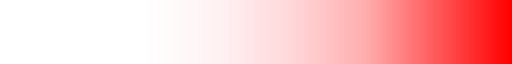

In [10]:
custom_cmap_less_aggresive = LinearSegmentedColormap.from_list('custom_cmap', less_aggresive_colors,)
custom_cmap_less_aggresive

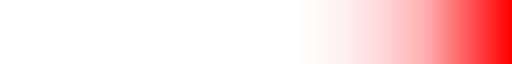

In [11]:
custom_cmap = LinearSegmentedColormap.from_list("custom_gradient", custom_colors)
custom_cmap

In [12]:
arab_results = arab_results.T

In [13]:
tomato_tcp = pd.read_csv('/data/passala/git/Solanum_SV_Pan_Genome/Miguel_macrocarpon/tomato_tcp.csv')

In [14]:
tomato_tcp

Tomato
0     Solyc01g016414
1     Solyc02g065800
2   Solyc02g077250.2
3   Solyc02g089020.2
4     Solyc02g089830
5     Solyc03g045030
6   Solyc03g115010.3
7   Solyc03g119770.4
8   Solyc04g006980.1
9   Solyc05g009900.3
10    Solyc05g012840
11    Solyc05g032780
12  Solyc06g069240.2
13  Solyc06g069460.3
14  Solyc07g053410.4
15  Solyc07g062680.3
16  Solyc08g048370.4
17  Solyc08g048390.3
18  Solyc10g008780.1
19    Solyc10g018710
20    Solyc10g082063
21    Solyc11g045640
22  Solyc12g014140.3

In [15]:
arabidopsis_tcp = pd.read_csv('/data/passala/git/Solanum_SV_Pan_Genome/Miguel_macrocarpon/arabi_tcp.csv')
arab_results = arab_results.loc[arab_results.index.isin(arabidopsis_tcp['Arabidopsis'].to_list())]
arab_results

tomato       Solyc01g008230.4  Solyc02g077250.2  Solyc02g089020.2  \
arabidopsis                                                         
AT1G30210            0.832639          0.845241          0.806982   
AT1G53230            0.695254          0.821621          0.805972   
AT1G58100            0.744448          0.530369          0.514668   
AT1G67260            0.567698          0.749347          0.754294   
AT1G68800            0.723340          0.827957          0.732199   
AT1G69690            0.855636          0.878061          0.691430   
AT1G72010            0.760700          0.618724          0.704536   
AT2G31070            0.683096          0.706143          0.862132   
AT2G37000            0.695341          0.726229          0.338899   
AT2G45680            0.558450          0.446374          0.530729   
AT3G02150            0.406133          0.386397          0.747647   
AT3G06975            0.501242          0.421303          0.592285   
AT3G15030            0.738056          0.821043          0.797221   
AT3G18550            0.443147          0.506732          0.671835   
AT3G27010            0.668579          0.486784          0.504139   
AT3G45150            0.587630          0.525022          0.501369   
AT3G47620            0.722427          0.761087          0.783410   
AT4G18390            0.781800          0.844418          0.818256   
AT5G08070            0.679384          0.758864          0.861148   
AT5G08330            0.814399          0.878046          0.725269   
AT5G23280            0.836384          0.896656          0.713470   
AT5G41030            0.768380          0.716413          0.521228   
AT5G51910            0.743492          0.830288          0.686859   
AT5G60970            0.726849          0.772106          0.937470   

tomato       Solyc02g094290.1  Solyc03g006800.1  Solyc03g115010.3  \
arabidopsis                                                         
AT1G30210            0.559607          0.699849          0.730634   
AT1G53230            0.429567          0.644482          0.847801   
AT1G58100            0.773057          0.559290          0.377441   
AT1G67260            0.221906          0.676297          0.902896   
AT1G68800            0.526890          0.695290          0.761396   
AT1G69690            0.446209          0.836255          0.657061   
AT1G72010            0.818912          0.560988          0.405274   
AT2G31070            0.458518          0.601651          0.865918   
AT2G37000            0.414048          0.888323          0.575928   
AT2G45680            0.624107          0.513148          0.399929   
AT3G02150            0.627721          0.266746          0.540497   
AT3G06975            0.563527          0.438610          0.431328   
AT3G15030            0.443403          0.634382          0.854554   
AT3G18550            0.609669          0.356873          0.557116   
AT3G27010            0.796625          0.572645          0.347567   
AT3G45150            0.457681          0.684012          0.610140   
AT3G47620            0.602762          0.650787          0.645613   
AT4G18390            0.476480          0.724775          0.833396   
AT5G08070            0.381071          0.648762          0.897929   
AT5G08330            0.427525          0.818376          0.725452   
AT5G23280            0.488134          0.774302          0.688652   
AT5G41030            0.610608          0.734056          0.484993   
AT5G51910            0.443589          0.748279          0.752707   
AT5G60970            0.522889          0.636466          0.893225   

tomato       Solyc03g116320.3  Solyc03g119770.4  Solyc04g006980.1  \
arabidopsis                                                         
AT1G30210            0.814379          0.721212          0.809355   
AT1G53230            0.761674          0.871259          0.865194   
AT1G58100            0.644061          0.404469          0.399470   
AT1G67260            0.682146          0.890998          0.887717

In [16]:
arab_results = arab_results[arab_results.columns.intersection(tomato_tcp['Tomato'].to_list())]
arab_results

tomato       Solyc02g077250.2  Solyc02g089020.2  Solyc03g115010.3  \
arabidopsis                                                         
AT1G30210            0.845241          0.806982          0.730634   
AT1G53230            0.821621          0.805972          0.847801   
AT1G58100            0.530369          0.514668          0.377441   
AT1G67260            0.749347          0.754294          0.902896   
AT1G68800            0.827957          0.732199          0.761396   
AT1G69690            0.878061          0.691430          0.657061   
AT1G72010            0.618724          0.704536          0.405274   
AT2G31070            0.706143          0.862132          0.865918   
AT2G37000            0.726229          0.338899          0.575928   
AT2G45680            0.446374          0.530729          0.399929   
AT3G02150            0.386397          0.747647          0.540497   
AT3G06975            0.421303          0.592285          0.431328   
AT3G15030            0.821043          0.797221          0.854554   
AT3G18550            0.506732          0.671835          0.557116   
AT3G27010            0.486784          0.504139          0.347567   
AT3G45150            0.525022          0.501369          0.610140   
AT3G47620            0.761087          0.783410          0.645613   
AT4G18390            0.844418          0.818256          0.833396   
AT5G08070            0.758864          0.861148          0.897929   
AT5G08330            0.878046          0.725269          0.725452   
AT5G23280            0.896656          0.713470          0.688652   
AT5G41030            0.716413          0.521228          0.484993   
AT5G51910            0.830288          0.686859          0.752707   
AT5G60970            0.772106          0.937470          0.893225   

tomato       Solyc03g119770.4  Solyc04g006980.1  Solyc05g009900.3  \
arabidopsis                                                         
AT1G30210            0.721212          0.809355          0.737018   
AT1G53230            0.871259          0.865194          0.790315   
AT1G58100            0.404469          0.399470          0.359583   
AT1G67260            0.890998          0.887717          0.873634   
AT1G68800            0.707276          0.835918          0.764537   
AT1G69690            0.584360          0.795990          0.717591   
AT1G72010            0.513769          0.473361          0.377743   
AT2G31070            0.931527          0.872478          0.850886   
AT2G37000            0.420824          0.601665          0.593268   
AT2G45680            0.434936          0.372295          0.377598   
AT3G02150            0.769018          0.489442          0.505563   
AT3G06975            0.470860          0.359301          0.356527   
AT3G15030            0.867723          0.883501          0.822545   
AT3G18550            0.658853          0.522467          0.494133   
AT3G27010            0.361097          0.383789          0.398203   
AT3G45150            0.457574          0.625303          0.582035   
AT3G47620            0.749193          0.687423          0.613105   
AT4G18390            0.829089          0.873145          0.822448   
AT5G08070            0.945908          0.879881          0.854403   
AT5G08330            0.756206          0.806959          0.763649   
AT5G23280            0.692241          0.795704          0.683620   
AT5G41030            0.396106          0.633957          0.541989   
AT5G51910            0.750911          0.767216          0.713294   
AT5G60970            0.960616          0.881883          0.867733   

tomato       Solyc06g069240.2  Solyc06g069460.3  Solyc07g053410.4  \
arabidopsis                                                         
AT1G30210            0.656858          0.739067          0.803712   
AT1G53230            0.754527          0.734793          0.857167   
AT1G58100            0.463550          0.518541          0.505080   
AT1G67260            0.773745          0.743729          0.821445

In [17]:
arab_results = arab_results.T

In [27]:
anat_clade_results = arab_results.loc[arab_results.index.isin(['Solyc06g069240.2','Solyc03g119770.4','Solyc05g009900.3','Solyc04g006980.1',' Solyc03g045030.2','Solyc02g089830.2'])]
anat_clade_results = anat_clade_results[anat_clade_results.columns.intersection(['AT1G67260','AT1G68800','AT3G18550', 'AT1G30210' , 'AT3G47620'])]

In [28]:
anat_clade_results

arabidopsis       AT1G30210  AT1G67260  AT1G68800  AT3G18550  AT3G47620
tomato                                                                 
Solyc03g119770.4   0.721212   0.890998   0.707276   0.658853   0.749193
Solyc04g006980.1   0.809355   0.887717   0.835918   0.522467   0.687423
Solyc05g009900.3   0.737018   0.873634   0.764537   0.494133   0.613105
Solyc06g069240.2   0.656858   0.773745   0.725998   0.626894   0.658170

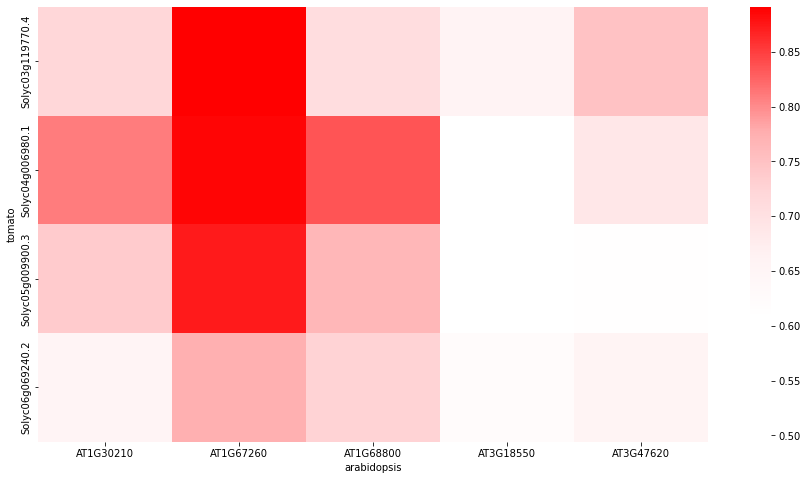

In [29]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.heatmap(anat_clade_results, cmap = custom_cmap_less_aggresive)

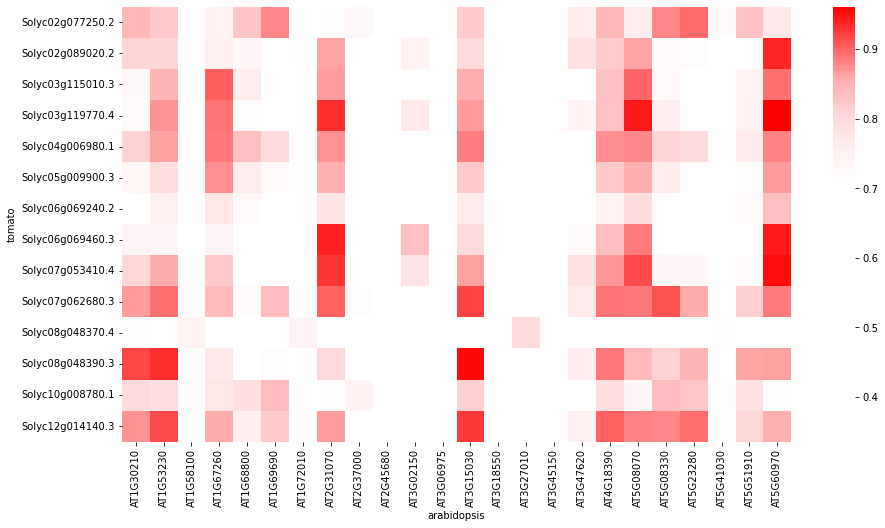

In [18]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.heatmap(arab_results, cmap = custom_cmap)

In [30]:
arab_results.loc['Solyc04g006980.1'].sort_values(ascending = False).head(10)

arabidopsis
AT1G67260    0.887717
AT3G15030    0.883501
AT5G60970    0.881883
AT5G08070    0.879881
AT4G18390    0.873145
AT2G31070    0.872478
AT1G53230    0.865194
AT1G68800    0.835918
AT1G30210    0.809355
AT5G08330    0.806959
Name: Solyc04g006980.1, dtype: float64

In [121]:
arab_results_cleaned = arab_results.drop(columns = ['AT1G58100', 'AT1G72010','AT2G37000','AT2G45680', 'AT3G18550','AT3G27010','AT3G45150','AT3G06975', 'AT5G41030'])

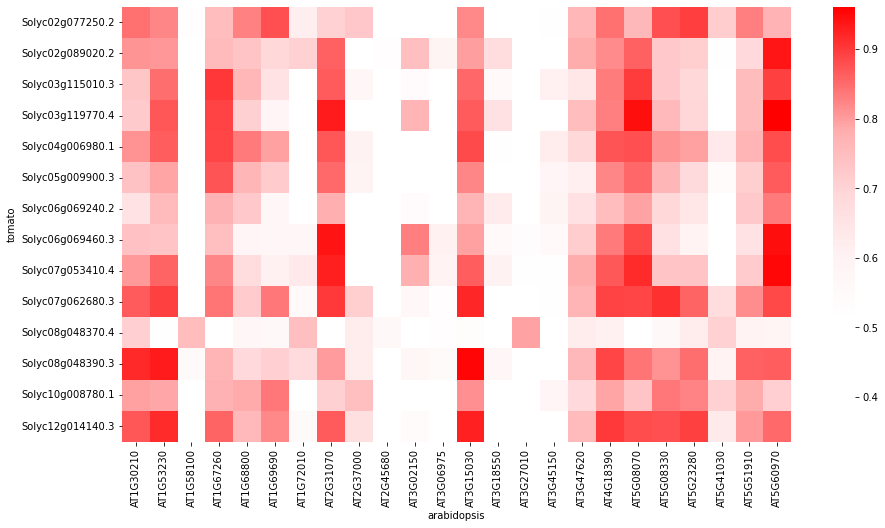

In [122]:
fig, ax = plt.subplots(figsize = (15,8))
ax = sns.heatmap(arab_results, cmap = custom_cmap_less_aggresive)

In [1]:
arab_results.loc['SOLYC04G006980']

NameError: name 'arab_results' is not defined

In [88]:
arab_results_cleaned

arabidopsis       AT1G30210  AT1G53230  AT1G67260  AT1G68800  AT1G69690  \
tomato                                                                    
Solyc02g077250.2   0.845241   0.821621   0.749347   0.827957   0.878061   
Solyc02g089020.2   0.806982   0.805972   0.754294   0.732199   0.691430   
Solyc03g115010.3   0.730634   0.847801   0.902896   0.761396   0.657061   
Solyc03g119770.4   0.721212   0.871259   0.890998   0.707276   0.584360   
Solyc04g006980.1   0.809355   0.865194   0.887717   0.835918   0.795990   
Solyc05g009900.3   0.737018   0.790315   0.873634   0.764537   0.717591   
Solyc06g069240.2   0.656858   0.754527   0.773745   0.725998   0.576578   
Solyc06g069460.3   0.739067   0.734793   0.743729   0.580200   0.573176   
Solyc07g053410.4   0.803712   0.857167   0.821445   0.676201   0.606806   
Solyc07g062680.3   0.866118   0.893175   0.838832   0.717911   0.837190   
Solyc08g048370.4   0.709444   0.524707   0.367584   0.573968   0.564926   
Solyc08g048390.3   0.916759   0.932973   0.768399   0.686532   0.709716   
Solyc10g008780.1   0.795337   0.789127   0.773308   0.785640   0.836719   
Solyc12g014140.3   0.870344   0.914237   0.856102   0.757495   0.821365   

arabidopsis       AT2G31070  AT3G02150  AT3G15030  AT3G47620  AT4G18390  \
tomato                                                                    
Solyc02g077250.2   0.706143   0.386397   0.821043   0.761087   0.844418   
Solyc02g089020.2   0.862132   0.747647   0.797221   0.783410   0.818256   
Solyc03g115010.3   0.865918   0.540497   0.854554   0.645613   0.833396   
Solyc03g119770.4   0.931527   0.769018   0.867723   0.749193   0.829089   
Solyc04g006980.1   0.872478   0.489442   0.883501   0.687423   0.873145   
Solyc05g009900.3   0.850886   0.505563   0.822545   0.613105   0.822448   
Solyc06g069240.2   0.778470   0.547605   0.767582   0.658170   0.748339   
Solyc06g069460.3   0.940434   0.829614   0.795487   0.715157   0.835495   
Solyc07g053410.4   0.928156   0.777423   0.863491   0.784674   0.869646   
Solyc07g062680.3   0.900285   0.569198   0.919401   0.767702   0.891405   
Solyc08g048370.4   0.503068   0.478095   0.536725   0.620548   0.604373   
Solyc08g048390.3   0.799731   0.578813   0.953334   0.759060   0.889686   
Solyc10g008780.1   0.708136   0.335537   0.811936   0.686392   0.790328   
Solyc12g014140.3   0.866461   0.545270   0.924538   0.755316   0.900945   

arabidopsis       AT5G08070  AT5G08330  AT5G23280  AT5G51910  AT5G60970  
tomato                                                                   
Solyc02g077250.2   0.758864   0.878046   0.896656   0.830288   0.772106  
Solyc02g089020.2   0.861148   0.725269   0.713470   0.686859   0.937470  
Solyc03g115010.3   0.897929   0.725452   0.688652   0.752707   0.893225  
Solyc03g119770.4   0.945908   0.756206   0.692241   0.750911   0.960616  
Solyc04g006980.1   0.879881   0.806959   0.795704   0.767216   0.881883  
Solyc05g009900.3   0.854403   0.763649   0.683620   0.713294   0.867733  
Solyc06g069240.2   0.793183   0.688112   0.643865   0.722077   0.835281  
Solyc06g069460.3   0.886431   0.660077   0.598591   0.655655   0.943892  
Solyc07g053410.4   0.914447   0.735253   0.731346   0.718066   0.952366  
Solyc07g062680.3   0.888040   0.910091   0.856148   0.814314   0.884988  
Solyc08g048370.4   0.478825   0.561453   0.622882   0.596421   0.586212  
Solyc08g048390.3   0.840018   0.810703   0.848248   0.860816   0.864351  
Solyc10g008780.1   0.734117   0.837087   0.824392   0.784042   0.709616  
Solyc12g014140.3   0.881239   0.878806   0.892525   0.802181   0.850752

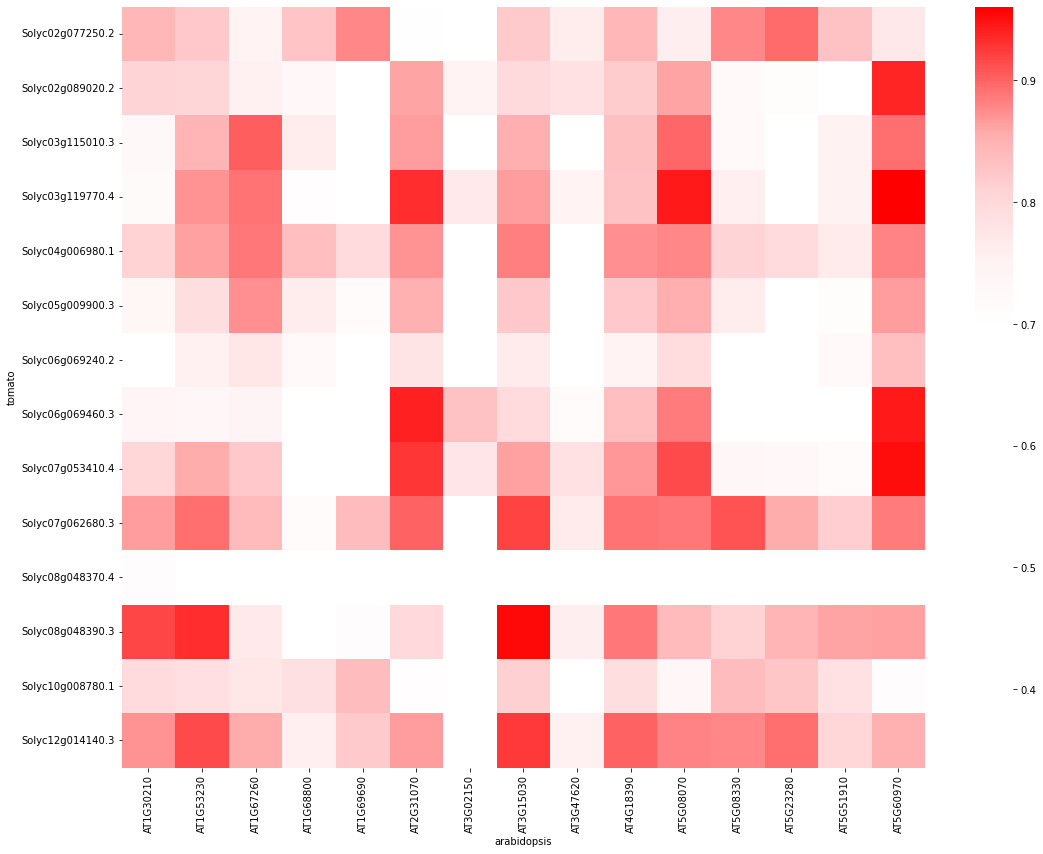

In [123]:
fig, ax = plt.subplots(figsize = (18,14))
ax = sns.heatmap(arab_results_cleaned, cmap = custom_cmap)

In [55]:
arab_results_cleaned

tomato       Solyc01g008230.4  Solyc02g077250.2  Solyc02g089020.2  \
arabidopsis                                                         
AT1G30210            0.832639          0.845241          0.806982   
AT1G53230            0.695254          0.821621          0.805972   
AT1G67260            0.567698          0.749347          0.754294   
AT1G68800            0.723340          0.827957          0.732199   
AT1G69690            0.855636          0.878061          0.691430   
AT2G31070            0.683096          0.706143          0.862132   
AT2G37000            0.695341          0.726229          0.338899   
AT3G15030            0.738056          0.821043          0.797221   
AT3G47620            0.722427          0.761087          0.783410   
AT4G18390            0.781800          0.844418          0.818256   
AT5G08070            0.679384          0.758864          0.861148   
AT5G08330            0.814399          0.878046          0.725269   
AT5G23280            0.836384          0.896656          0.713470   
AT5G41030            0.768380          0.716413          0.521228   
AT5G60970            0.726849          0.772106          0.937470   

tomato       Solyc03g006800.1  Solyc03g115010.3  Solyc03g116320.3  \
arabidopsis                                                         
AT1G30210            0.699849          0.730634          0.814379   
AT1G53230            0.644482          0.847801          0.761674   
AT1G67260            0.676297          0.902896          0.682146   
AT1G68800            0.695290          0.761396          0.776437   
AT1G69690            0.836255          0.657061          0.815190   
AT2G31070            0.601651          0.865918          0.768944   
AT2G37000            0.888323          0.575928          0.583513   
AT3G15030            0.634382          0.854554          0.809394   
AT3G47620            0.650787          0.645613          0.809427   
AT4G18390            0.724775          0.833396          0.852695   
AT5G08070            0.648762          0.897929          0.768088   
AT5G08330            0.818376          0.725452          0.770478   
AT5G23280            0.774302          0.688652          0.826437   
AT5G41030            0.734056          0.484993          0.661824   
AT5G60970            0.636466          0.893225          0.861883   

tomato       Solyc03g119770.4  Solyc04g006980.1  Solyc04g009180.3  \
arabidopsis                                                         
AT1G30210            0.721212          0.809355          0.838607   
AT1G53230            0.871259          0.865194          0.748841   
AT1G67260            0.890998          0.887717          0.628187   
AT1G68800            0.707276          0.835918          0.817840   
AT1G69690            0.584360          0.795990          0.924633   
AT2G31070            0.931527          0.872478          0.687024   
AT2G37000            0.420824          0.601665          0.639440   
AT3G15030            0.867723          0.883501          0.760827   
AT3G47620            0.749193          0.687423          0.850287   
AT4G18390            0.829089          0.873145          0.836096   
AT5G08070            0.945908          0.879881          0.712111   
AT5G08330            0.756206          0.806959          0.871786   
AT5G23280            0.692241          0.795704          0.904310   
AT5G41030            0.396106          0.633957          0.745787   
AT5G60970            0.960616          0.881883          0.782042   

tomato       Solyc05g007420.2  Solyc05g009900.3  Solyc06g065190.1  \
arabidopsis                                                         
AT1G30210            0.762108          0.737018          0.783877   
AT1G53230            0.781395          0.790315          0.756098   
AT1G67260            0.776887          0.873634          0.613390   
AT1G68800            0.866886          0.764537          0.749664   
AT1G69690            0.781063          0.717591          0.83205